In [263]:
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras import models

In [264]:
import numpy as np
import keras
import warnings
from matplotlib import pyplot as plt
import cv2
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import preprocess_input
import random

In [277]:
def image_process(img,r_size,c_size):
    scaled_image = cv2.resize(img, (r_size, c_size))
    #rot_image = np.rot90(scaled_image,-1)
    return scaled_image

In [278]:
dire = ''
filename = 'yeah2.mov'

In [279]:
def extract_image_data(dire = dire, filename = filename,r_size=224,c_size=224):
    file = dire+ filename
    vidcap = cv2.VideoCapture(file)
    flag = True
    image_list = []
    cnt = 0
    while flag:
        flag,img = vidcap.read()
        if flag:
            image_list += [image_process(img,r_size,c_size)]
            cnt += 1
    return image_list

In [280]:
image_list = extract_image_data(dire,filename)
print(image_list[0].shape)
print(len(image_list))

(224, 224, 3)
296


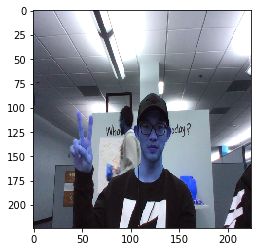

In [281]:
imgplot = plt.imshow(image_list[0])

In [282]:
image_dataset = []
category_dataset = []
cat = 0
proj = {}
for filename in ['fist2.mov','five2.mov','thumb2.mov','yeah2.mov']:
    image_list = extract_image_data(dire,filename)
    image_dataset += image_list
    category_dataset += [cat for _ in image_list]
    proj[cat] = filename.split('.')[0]
    cat += 1
image_dataset = np.asarray(image_dataset)
category_dataset = np.asarray(category_dataset)
category_dataset = keras.utils.to_categorical(category_dataset)

In [283]:
print(image_dataset.shape)
print(category_dataset.shape)

(1809, 224, 224, 3)
(1809, 4)


In [284]:
r_size=224
c_size=224
model = keras.applications.MobileNet(include_top=False,  weights='imagenet', input_shape=(r_size, c_size, 3),  pooling=None)

In [285]:
#print(model.summary())

In [286]:
%%time
processed_input = model.predict(image_dataset)

CPU times: user 6min 15s, sys: 48.6 s, total: 7min 4s
Wall time: 24.4 s


In [287]:
print(image_dataset[0].shape)
print(processed_input.shape)

(224, 224, 3)
(1809, 7, 7, 1024)


In [291]:
print(category_dataset.shape)

(1809, 4)


In [292]:
top_model = models.Sequential()
top_model.add(layers.Flatten(input_shape=(7, 7, 1024)))
#top_model.add(layers.Dense(128, activation='relu'))
#top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dense(128, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(64, activation='relu'))
top_model.add(layers.Dense(4, activation='softmax'))

top_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [293]:
top_model.fit(processed_input, category_dataset, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
1809/1809 [==============================] - 7s 4ms/step - loss: 5.5332 - acc: 0.5931
Epoch 2/10
1809/1809 [==============================] - 1s 466us/step - loss: 0.9122 - acc: 0.8883
Epoch 3/10
1809/1809 [==============================] - 1s 470us/step - loss: 0.2687 - acc: 0.9541
Epoch 4/10
1809/1809 [==============================] - 1s 481us/step - loss: 0.4360 - acc: 0.9469
Epoch 5/10
1809/1809 [==============================] - 1s 496us/step - loss: 0.0749 - acc: 0.9801
Epoch 6/10
1809/1809 [==============================] - 1s 478us/step - loss: 0.2610 - acc: 0.9668
Epoch 7/10
1809/1809 [==============================] - 1s 481us/step - loss: 0.0929 - acc: 0.9735
Epoch 8/10
1809/1809 [==============================] - 1s 485us/step - loss: 0.2050 - acc: 0.9679
Epoch 9/10
1809/1809 [==============================] - 1s 478us/step - loss: 0.0578 - acc: 0.9823
Epoch 10/10
1809/1809 [==============================] - 1s 474us/step - loss: 0.2290 - acc: 0.9679


In [296]:
pred = [proj[i] for i in top_model.predict_classes(processed_input)]

In [297]:
#save trained model
from keras.models import load_model

top_model.save('top_model.h5')
del top_model

In [298]:
#load trained model
top_model = load_model('top_model.h5')

In [299]:
def get_command(img,r_size=224,c_size=224):
    scaled_image = cv2.resize(img, (r_size, c_size))
    cmd_id = top_model.predict_classes(model.predict(np.asarray([scaled_image])))[0]
    return cmd_id

thumb2
CPU times: user 296 ms, sys: 61.9 ms, total: 357 ms
Wall time: 43.2 ms


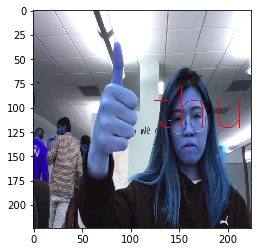

In [305]:
%%time
frame = image_dataset[1200]
cmd_id = get_command(frame)
cmd = proj[cmd_id]
print(cmd)
plt.imshow(cv2.putText(frame,cmd, (120,120), cv2.FONT_HERSHEY_SIMPLEX, 2, 255))

In [301]:
%%time
a = model.predict(np.asarray([cv2.resize(frame, (r_size, c_size))]))

CPU times: user 295 ms, sys: 13.1 ms, total: 308 ms
Wall time: 20.2 ms


In [302]:
image_dataset[530].shape

(224, 224, 3)